In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import numpy as np
from bnb.problem import OptimizationProblem
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import minimize
import pandas as pd
from bnb.fml_solver import FMLSolver
import warnings
import time
from bnb.gradient_descent import GradientDescent
import seaborn as sns

from autograd.scipy.special import logsumexp
from autograd import jacobian
import autograd.numpy as anp

sns.set()
matplotlib.rcParams.update({'font.size': 11, 'font.family': 'serif'})

In [42]:
n = 2
n_choices = int(1e6)
runs = 750
m = 2

In [43]:
class DataSimulator(OptimizationProblem):
    
    def revenue_true(self, p):
        return np.sum([
            segment.w * np.sum(p * segment.purchase_probabilities(p))
            for segment in self.segments
        ])
    
    def simulate_choices(self, n_observations, seed=None):
        
        np.random.seed(seed)
        
        observed_prices = np.random.uniform(self.p_lb, self.p_ub, size=(n_observations, self.n))
        
        purchase_probabilities = np.asarray([
            np.sum([segment.w * segment.purchase_probabilities(price) for segment in self.segments], axis=0)
            for price in observed_prices
        ])
            
        assert purchase_probabilities.shape == (n_observations, self.n)
        
        # 0 is first product, n is no purchase
        observed_choices = np.sum(
            np.cumsum(purchase_probabilities, axis=1) < np.random.uniform(size=(n_observations, 1)),
            axis=1
        )
        
        return observed_prices, observed_choices
    
    
def logit_loglikelihood(params, observed_choices, observed_prices):
    
    assert len(params) == 2 * n
    a, b = params[:n], params[n:]
    n_choices = len(observed_choices)
    
    utilities = a - b * observed_prices
    assert utilities.shape == (n_choices, n)
    
    utilities = anp.concatenate((utilities, anp.zeros((n_choices, 1))), axis=1)
    assert utilities.shape == (n_choices, n + 1)
    
    utilities_chosen_products = utilities[anp.arange(n_choices), observed_choices]
    assert utilities_chosen_products.shape == (n_choices, ), utilities_chosen_products.shape

    log_probs = - logsumexp(utilities - anp.expand_dims(utilities_chosen_products, -1), axis=-1)
    assert log_probs.shape == (n_choices, ), log_probs.shape
    
    return - anp.sum(log_probs) / n_choices

In [54]:
from tqdm import tqdm

def _keep_significant(opt):
    
    standard_errors = np.sqrt(np.diag(opt.hess_inv) / n_choices)
    a_std, b_std = standard_errors[:n], standard_errors[n:]
    a, b = best_result.x[:n], best_result.x[n:]
    
    to_drop_a = np.argwhere(((a - 1.96 * a_std) <= 0) & ((a + 1.96 * a_std) <= 0))[:, 0]
    to_drop_b = np.argwhere(((b - 1.96 * b_std) <= 0) & ((b + 1.96 * b_std) <= 0))[:, 0]
    
    to_drop = np.sort(list(set(to_drop_a).union(set(to_drop_b))))
    to_keep = [i for i in range(n) if i not in to_drop]
    return to_keep


results = []
for run in tqdm(range(runs)):
    
    t0 = time.time()
    np.random.seed(run)

    a0 = np.random.uniform(-7, 7, size=(m, n))
    b0 = np.random.uniform(0.001, 0.01, size=n)

    w0 = np.asarray([0.5, 0.5])
    
    gd = GradientDescent(a0, b0, w0)
    gd_sol = gd.solve()

    true_demand = DataSimulator(a0, b0, w0)
    solver = FMLSolver(true_demand, objective_lb=gd_sol, epsilon=0.005)
    solver.solve()

    # Simulate data
    observed_prices, observed_choices = true_demand.simulate_choices(n_choices, seed=run)

    # Estimate logit model
    t0 = time.time()
    a_start = np.mean(a0, axis=0)
    b_start = b0
    best_result = None
    any_success = False
    
    for attempt in range(1):
        
        parameter_start = np.hstack((a_start, b_start))

        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore", category=RuntimeWarning)
            jac = jacobian(logit_loglikelihood)
            min_ll = minimize(
                logit_loglikelihood,
                parameter_start,
                args=(observed_choices, observed_prices),
                jac=jac
            )
            
        any_success = any_success or min_ll.success

        if best_result is None:
            best_result = min_ll

        if min_ll.fun < best_result.fun:
            best_result = min_ll
        
        a_start, b_start = np.random.uniform(0, 8, size=n), np.random.uniform(0.0, 1.0, size=n)
    
    if not any_success:
        raise ValueError("All optimization attempts failed.")
    
    a, b = best_result.x[:n], best_result.x[n:]
    print(f"estimated logit model in {time.time() - t0:.0f} seconds.")

    # Optimize revenue under logit model specification (i.e., FML with one segment)
    opt = OptimizationProblem(np.asarray([a]), b, np.ones(1))
    opt_logit_prices = 1 / b + opt.segments[0].rev_opt
    p = opt_logit_prices
    logit_rev = true_demand.revenue_true(p)
    opt_rev = solver.objective_lb
    
    results.append({
        "opt_rev": opt_rev,
        "logit_rev": logit_rev,
        "logit_par": (a, b),
        "real_par": (a0, b0, w0),
        "run": run
    })
      
    print(f"logit rev {logit_rev}, opt rev {opt_rev}")

LB: 609.8338967156327, UB: inf.
number of cubes:  4
LB: 609.8338967156327, UB: 833.4755800990158.
number of cubes:  8
LB: 609.8338967156327, UB: 729.5092399773091.
number of cubes:  16
LB: 609.8338967156327, UB: 670.4216737633031.
number of cubes:  36
LB: 609.8338967156327, UB: 640.2736317035418.
number of cubes:  72
LB: 609.8338967156327, UB: 621.5834924825881.
number of cubes:  136
LB: 609.8338967156327, UB: 617.2572578551944.
number of cubes:  180
LB: 609.8338967156327, UB: 610.9206675537388.
estimated logit model in 12 seconds.
logit rev 0.0031460714249433876, opt rev 609.8338967156327


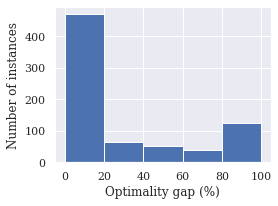

In [50]:
import matplotlib
matplotlib.rcParams.update({'font.size': 11, 'font.family': 'serif'})

_, ax = plt.subplots(figsize=(4, 3))

df = (
    pd.DataFrame
    .from_records(results)
    .assign(
        gap=lambda df: (
            df["opt_rev"]
            .subtract(df["logit_rev"])
            .divide(df["opt_rev"])
            .multiply(100)
        )
    )
)

df["gap"].hist(bins=5, ax=ax)

ax.set_xlabel("Optimality gap (%)")
ax.set_ylabel("Number of instances")
plt.tight_layout()
plt.savefig("../figs/histogram-optgap.pdf")
plt.show()